In [1]:
# given a json file / collection of sentences - run some basic analysis

import json
import os
import re
import time
import gzip
import itertools


import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


try:
    # python package (nlp) location - two levels up from this file
    src_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
    # add package to sys.path if it's not already there
    if src_path not in sys.path:
        sys.path.extend([src_path])
except NameError:
    print('issue with adding to path, probably due to __file__ not being defined')
    src_path = None


from nlp.utils import get_database, niave_long_to_short_name, get_knowledge_base_from_value_chain_data
from nlp import get_configs_path, get_data_path


## Load Data

In [2]:

# # ----
# # parameters
# # ----

# # if True will read articles from local json file: data/articles.json
# # - this can reduce burden on the remote database (network usage)
# read_local_articles = True

# # make number of sentences to combine
# max_num_sentences_to_combine = 5

# # ----
# # connect to database
# # ----

# # get credentials
# with open(get_configs_path("mongo.json"), "r+") as f:
#     mdb_cred = json.load(f)

# # get mongodb client - for connections
# client = get_database(username=mdb_cred["username"],
#                         password=mdb_cred["password"],
#                         clustername=mdb_cred["cluster_name"])

# # --
# # get knowledge base
# # --

# # ---
# # read in value chain data / knowledge base
# # ---

# vc = pd.DataFrame(list(client["refinitiv"]["VCHAINS"].find(filter={})))

# # there are some missing comany names? exclude those
# vc = vc.loc[~pd.isnull(vc['Company Name'])]

# # the knowledge base
# kb = get_knowledge_base_from_value_chain_data(vc)

# # ---
# # read in article data - for reference
# # ---

# # read proof of concept data
# assert os.path.exists(get_data_path("articles.json")), \
#     f"{get_data_path('articles.json')} does not exist, get from the google drive and save locally"

# with open(get_data_path("articles.json"), "r") as f:
#     article_list = json.load(f)

# articles = {re.sub("\.json$", "", f["json_file"]): f
#             for f in article_list if "names_in_text" in f}


In [3]:
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_colwidth", 70)

In [4]:
#Read in VC File Locally Locally

assert os.path.exists(get_data_path("VCHAINS.csv")), \
    f"looks like: {get_data_path('VCHAINS.csv')}, pull from git to have it in the data folder"
vc = pd.read_csv(get_data_path("VCHAINS.csv"))

# there are some missing comany names? exclude those
vc = vc.loc[~pd.isnull(vc['Company Name'])]

# the knowledge base
kb = get_knowledge_base_from_value_chain_data(vc)


In [5]:
#Load in Input file including with Weak Labels
assert os.path.exists(get_data_path("text_with_weak_labels.json")), \
    f"looks like: {get_data_path('text_with_weak_labels.json')}, copy from google drive data/text_with_weak_labels.json"

with open(get_data_path("text_with_weak_labels.json"), "r") as f:
    full_sents = json.load(f)

In [6]:
#Conver to DF and do simple processing

df = pd.DataFrame(full_sents)

#Create Label column for KB label
label = np.ones(df.shape[0]).astype(int)
label[df['relation']=="NA"] = 0
df.loc[:,'KB_label'] = label

#Removing instnaces with <=30 characters
print(df.shape)
df.drop(df[df['text'].apply(len)<=30].index, inplace = True)
print(df.shape)

#For now replace () with [] -> This should not be necessary later
df.loc[:,"text_with_marker"] = [row[0].replace(row[1],'{'+row[1]+'}') for row in zip(df['text'],df['entity1'])]
df.loc[:,"text_with_marker"] = [row[0].replace(row[1],'['+row[1]+']') for row in zip(df['text_with_marker'],df['entity2'])]

# #Drop relation column
# df_data.drop('relation',axis=1,inplace=True)

(146207, 25)
(146066, 25)


## Removing bi-directional sentences

### Analysis

### Remove from DF

## Num Sentences limited to 3

### Analysis

<AxesSubplot:>

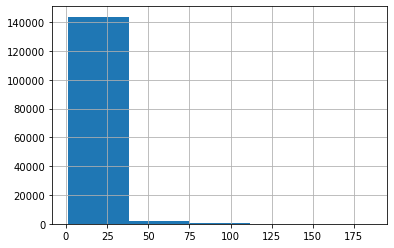

In [7]:
df['num_sentence'].hist(bins=5)

<AxesSubplot:>

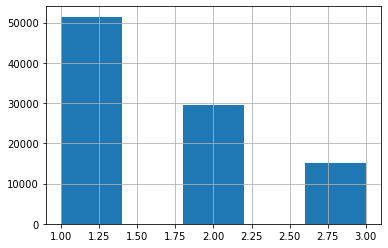

In [8]:
df.loc[df['num_sentence']<=3,'num_sentence'].hist(bins=5)

In [9]:
df.sort_values('num_sentence',ascending=False)[:20].loc[:,['entity1','entity2','text','num_sentence']]

,entity1,entity2,text,num_sentence
109189,Exxon Mobil,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,186
146027,Cadence,Exxon Mobil,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,182
95282,Chevron,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,180
140263,Interpublic,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,179
105487,Exxon Mobil,Alphabet,Alphabet Earnings Release O 23-Apr-2018 AMC ZION.O Zions Bancorp Q...,178
136284,Halliburton,Phillips 66,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,176
146025,Cadence,Chevron,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,176
142036,Interpublic,Cadence,Cadence Earnings Release 23-Apr-2018 AMC AMP.N Ameriprise Financia...,175
142005,Charter,Halliburton,Alaska Air Group Inc Earnings Release 23-Apr-2018 BMO HAL.N Hallib...,173
114861,Chevron,Alphabet,Alphabet Earnings Release O 23-Apr-2018 AMC ZION.O Zions Bancorp Q...,172


### Removing the instances with >2 sentences

In [10]:
#Removing sentences with num_sentences>2, i.e. can only be 2 sentence long
df_short_dist = df.loc[df["num_sentence"]<3,:] 

print("{}% articles have max 1 sentence in between two entity mentions".format(np.round(df.loc[df["num_sentence"]<3,:].shape[0]/df.shape[0],2)*100))
print("{} out of {} sentences left".format(df.loc[df["num_sentence"]<3,:].shape[0],df.shape[0]))

df = df.loc[df["num_sentence"]<3,:] 

56.00000000000001% articles have max 1 sentence in between two entity mentions
81088 out of 146066 sentences left


## #Articles per pair

### Analysis

unique relations: ['Supplier' 'NA']
number of unique articles: 22294
count of 'relation'
           text
relation       
NA        27219
Supplier  53869
average extract sentences per article: 3.64


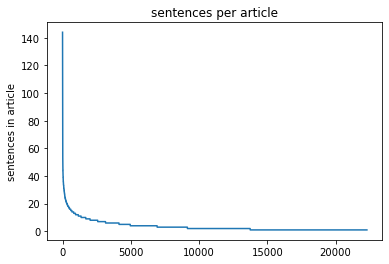

top articles:


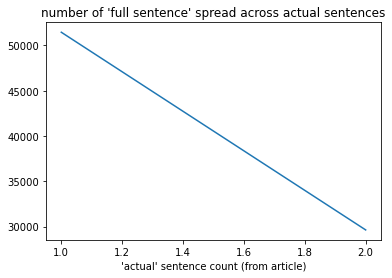

13.170050349196037

In [11]:
# ---
# get counts of occurrences / summary statistics
# ---

df.head()

print(f"unique relations: {df['relation'].unique()}")

print(f"number of unique articles: {len(df['article'].unique())}")

# ---
# count of relation
# ---
relation_count = pd.pivot_table(df,
                                index="relation",
                                values="text",
                                aggfunc="count")
print("count of 'relation'")
print(relation_count)

# ---
# sentences per articles
# ---

sent_per_art = pd.pivot_table(df, index='article', values="text", aggfunc='count')
sent_per_art = sent_per_art.reset_index()
sent_per_art.sort_values("text", ascending=False, inplace=True)

print(f"average extract sentences per article: {sent_per_art['text'].mean():.2f}")

plt.plot(sent_per_art['text'].values)
plt.title("sentences per article")
plt.ylabel("sentences in article")
plt.show()

# there is heavy skew
print("top articles:")
#print(sent_per_art.head(20))

sent_per_art.loc[sent_per_art['text'] < 10, 'text'].mean()

# ---
# sentence spread - entity pair can exist across multiple sentence - consider those
# ---

num_sent = pd.pivot_table(df,
                            index='num_sentence',
                            values="text",
                            aggfunc="count")

plt.plot(num_sent)
plt.title("number of 'full sentence' spread across actual sentences")
plt.xlabel("'actual' sentence count (from article)")
plt.show()

# ---
# sentences per pair
# ---

sentence_per_triple = pd.pivot_table(df,
                                        index=["entity1_full", "entity2_full", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()

sentence_per_triple['text'].mean()


In [12]:
#Looking at sentence per triple
sentence_per_triple['pair'] = sentence_per_triple['entity1_full'] + '-' + sentence_per_triple['entity2_full']
sentence_per_triple.sort_values('text',ascending=False)
label = np.ones(sentence_per_triple.shape[0]).astype(int)
label[sentence_per_triple['relation']=="NA"] = 0
sentence_per_triple.loc[:,'label'] = label


print("For Positive and Negative Examples")
print(sentence_per_triple.loc[:,['pair','text']].describe().round(0))
print("")


For Positive and Negative Examples
         text
count  6157.0
mean     13.0
std      69.0
min       1.0
25%       1.0
50%       2.0
75%       5.0
max    2092.0



In [13]:
print("For Positive")
print(sentence_per_triple.loc[sentence_per_triple['label']==1,['pair','text']].describe().round(0))
print('')

For Positive
         text
count  1757.0
mean     31.0
std     110.0
min       1.0
25%       2.0
50%       4.0
75%      16.0
max    2092.0



In [14]:
print("For Negative")
print(sentence_per_triple.loc[sentence_per_triple['label']==0,['pair','text']].describe().round(0))

For Negative
         text
count  4400.0
mean      6.0
std      42.0
min       1.0
25%       1.0
50%       1.0
75%       3.0
max    1841.0


In [15]:
sentence_per_triple

,entity1_full,entity2_full,relation,text,pair,label
0,A123 Systems Inc,Ford Motor Co,NA,1,A123 Systems Inc-Ford Motor Co,0
1,AAC Technologies Holdings Inc,LG Innotek Co Ltd,NA,3,AAC Technologies Holdings Inc-LG Innotek Co Ltd,0
2,AAC Technologies Holdings Inc,Panasonic Corp,NA,1,AAC Technologies Holdings Inc-Panasonic Corp,0
3,AMC Networks Inc,Cablevision Systems Corp,Supplier,1,AMC Networks Inc-Cablevision Systems Corp,1
4,ANA Holdings Inc,Aeon Co Ltd,NA,1,ANA Holdings Inc-Aeon Co Ltd,0
...,...,...,...,...,...,...
6152,Zynga Inc,Snap Inc,NA,2,Zynga Inc-Snap Inc,0
6153,eBay Inc,Amazon.com Inc,Supplier,40,eBay Inc-Amazon.com Inc,1
6154,eBay Inc,Microsoft Corp,Supplier,1,eBay Inc-Microsoft Corp,1
6155,eBay Inc,Nike Inc,NA,2,eBay Inc-Nike Inc,0


In [16]:
#See which pairs are with many examples 
sentence_per_triple.loc[sentence_per_triple['label']==0,['pair','text']].sort_values('text',ascending=False)[:30]

,pair,text
4537,Samsung Electronics Co Ltd-Apple Inc,1841
398,Amazon.com Inc-Apple Inc,1451
3390,Microsoft Corp-Amazon.com Inc,612
967,Bombardier Inc-Boeing Co,433
2677,Intel Corp-Apple Inc,431
907,Boeing Co-Airbus SE,378
491,Amazon.com Inc-Walmart Inc,365
3751,Netflix Inc-Apple Inc,316
5501,Toyota Motor Corp-Volkswagen AG,298
446,Amazon.com Inc-Microsoft Corp,273


In [17]:
#See impact on corpus
for i in [5,10,15,20,25,4000]:
    print("Negative: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[sentence_per_triple['label'] ==0 ,"text"].clip(upper=i).sum())
    print("Positive: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[sentence_per_triple['label'] ==1 ,"text"].clip(upper=i).sum())
    print("Total: Cap: {}, examples left: ".format(i), sentence_per_triple.loc[:,"text"].clip(upper=i).sum())
    print("")

Negative: Cap: 5, examples left:  9681
Positive: Cap: 5, examples left:  6077
Total: Cap: 5, examples left:  15758

Negative: Cap: 10, examples left:  12303
Positive: Cap: 10, examples left:  9549
Total: Cap: 10, examples left:  21852

Negative: Cap: 15, examples left:  13848
Positive: Cap: 15, examples left:  12132
Total: Cap: 15, examples left:  25980

Negative: Cap: 20, examples left:  14943
Positive: Cap: 20, examples left:  14249
Total: Cap: 20, examples left:  29192

Negative: Cap: 25, examples left:  15786
Positive: Cap: 25, examples left:  16050
Total: Cap: 25, examples left:  31836

Negative: Cap: 4000, examples left:  27219
Positive: Cap: 4000, examples left:  53869
Total: Cap: 4000, examples left:  81088



In [18]:
sentence_per_triple.sort_values('text',ascending=False)[:100]

,entity1_full,entity2_full,relation,text,pair,label
2173,General Motors Co,Ford Motor Co,Supplier,2092,General Motors Co-Ford Motor Co,1
1971,Ford Motor Co,General Motors Co,Supplier,2092,Ford Motor Co-General Motors Co,1
4537,Samsung Electronics Co Ltd,Apple Inc,NA,1841,Samsung Electronics Co Ltd-Apple Inc,0
398,Amazon.com Inc,Apple Inc,NA,1451,Amazon.com Inc-Apple Inc,0
642,Apple Inc,Microsoft Corp,Supplier,1354,Apple Inc-Microsoft Corp,1
...,...,...,...,...,...,...
623,Apple Inc,Huawei Technologies Co Ltd,Supplier,165,Apple Inc-Huawei Technologies Co Ltd,1
940,Boeing Co,Northrop Grumman Corp,Supplier,165,Boeing Co-Northrop Grumman Corp,1
1078,Caterpillar Inc,Boeing Co,Supplier,161,Caterpillar Inc-Boeing Co,1
420,Amazon.com Inc,FedEx Corp,Supplier,160,Amazon.com Inc-FedEx Corp,1


In [19]:
sent_per_art[:50]

,article,text
15449,9dab9253e2cea5262f91e2917579b4551f225ef9c92908a2cf76655d0b454578,144
13015,805f831505530537d858a8335cfa498dec686a80cbfed406059369a90e3f2bff,134
7766,46bc17c301f9881f15bdafd19184ba5545895b162bd4f46c296f567a609e9d54,118
6605,3b5173f9ba5a45605fb41d170231824f40e3b903f805dcee07b747455491b418,88
1412,0bd3c52d7efada74fa318750007e052c0bcd5fe6221191daf3717fbc897ab623,83
819,06960d7b41a670cb50a1f8e7107e514dd5c82c63c849957ad6ce87ec7d036e02,82
5063,2c8e46fcd5978965ff63f18583b8f703db7a9d2e29f5d9f1aa44a07e00e9956a,73
848,06d305860c66b48dd7c037f832ad2ac58939479891acc380104120a159652c65,63
2128,11d8951cf5fff9696cf6cfa91da15872fba5dee0c416bd923d169edf8f207631,63
1640,0dbc57049c5480b95feee646f51c8f1e1c9000635c4d56f833d34015370383cd,62


### Sampling articles such that each pair has a maximum of 20 articles

In [20]:
#Add a pair column to loop through
df.loc[:,'pair'] = df['entity1_full']+'|'+ df['entity2_full']

df_pivot = pd.pivot_table(df,
                                        index=["pair", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()



In [21]:
#Sampling Randomly
cutoff = 20
df_list = []
random_state = 13 

for pair in df_pivot['pair'].values:
    n = np.clip(df_pivot.loc[df_pivot['pair']==pair,'text'],0,cutoff).values[0]
    df_list.append(df.loc[df['pair'] == pair,:].sample(n,random_state=random_state,replace=False))

df = pd.concat(df_list,axis=0)
df.reset_index(drop=True,inplace=True)    

array([[<AxesSubplot:title={'center':'text'}>]], dtype=object)

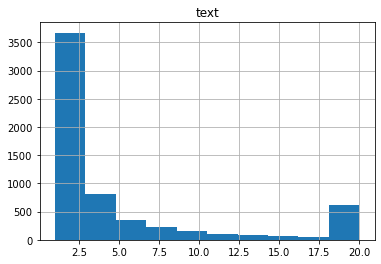

In [22]:
#Check the results
df_pivot_test = pd.pivot_table(df,
                                        index=["pair", "relation"],
                                        values=["text"],
                                        aggfunc="count").reset_index()

df_pivot_test.sort_values('text',ascending=False).hist()

## Splitting the Data into Train/Dev/Test

### Split functions (From Joe's Notebook with small amendment)

In [23]:
def stanford_split(kb, corpus, split_ratios = [0.6, 0.2, 0.2], random_seed = 0, verbose = True):
    np.random.seed(random_seed)

    assert sum(split_ratios) == 1, 'Split Ratios do not add up to 1'

    # Randomly split the subjects in the KB between train/dev/test splits 
    # TODO: Random number generation split does not create exact splits - make this exact with length split instead (but works for now)
    def subject_split(kb, split_ratios):
        subjects = pd.DataFrame(kb.subject.unique()).rename(columns = {0: 'subject'})
        subjects['split'] = [np.random.choice(3, p =  split_ratios) for _ in range(len(subjects))] 
        return subjects

    if verbose: pass

    # Merge split numbers for subjects (E1) back onto kb df
    kb_with_splits = kb.merge(subject_split(kb, split_ratios), how = 'left', on = 'subject')

    split_dict = {sbj: split for sbj, split in zip(kb_with_splits.subject, kb_with_splits.split)}

    corpus_with_splits = corpus.copy()

    # Use stanford Rule:
    # If E1 in corpus in a KB split -> place sentence to that split.
    # Else if E2 in corpus in a KB split -> place sentance to that split.
    # If neither of above, assign sentence to random split.
    splits = []
    count_not_matched = 0
    for E1, E2 in zip(corpus_with_splits.entity1_full, corpus_with_splits.entity2_full): 
        if E1 in split_dict.keys():
            splits.append(split_dict[E1])
        elif E2 in split_dict.keys():
            splits.append(split_dict[E2])
        else:
            splits.append(np.random.choice(3, p = split_ratios))
            if verbose: print('{}, {} not in KB split' .format(E1, E2))
            count_not_matched += 1
    print('Total of {} entries in corpus not matched to KB. \n' .format(count_not_matched))
    corpus_with_splits['split'] = splits

    # if verbose:
    print('KB split ratios: \n {} \n' .format(kb_with_splits.split.value_counts(normalize = True)))
    print('Corpus split ratios: \n {} \n' .format(corpus_with_splits.split.value_counts(normalize = True)))

    return kb_with_splits, corpus_with_splits


In [24]:
def corpus_density_based_split(corpus, kb, split_ratios = np.array([0.6,0.2,0.2]), labelcol = 'label', random_seed = 0, verbose = True):
    np.random.seed(random_seed)
    corp = corpus.copy()
    _kb = kb.copy()

    # Create an alphabetically sorted (E1, E2) tuple column of the two entities mentioned in each row
    corp['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(corp.entity1_full, corp.entity2_full)]       
    
    # Create a df which contains the number of entries per unique E1,E2 pair in corpus and sort in descending order
    corpus_counts = corp.groupby(['relation_tuple']).agg('size').reset_index().sort_values(by = 0, ascending=False).rename(columns = {0: 'sentence_counts'})

    _counts_per_split = corpus_counts.sentence_counts.sum() * split_ratios
    _counts_cumsum = _counts_per_split.cumsum()
    print('Aim to have approx {} entries per train/dev/test split, respectively.\n' .format(_counts_per_split))

    # Shuffle this to get rid of numerical order 
    shuffled_corpus_counts = corpus_counts.sample(frac=1, random_state = 42) # Perhaps we can also find deterministic "shuffle"

    # Now add column which gives cumulative counts of sentences down Pairs
    shuffled_corpus_counts['sentence_cumsum'] = np.cumsum(shuffled_corpus_counts.sentence_counts)

    def assign_splits(corpus_counts, counts_cumsum):
        splits = []
        for scs in corpus_counts.sentence_cumsum:
            if scs <= counts_cumsum[0]: splits.append(0)
            elif scs > counts_cumsum[0] and scs <= counts_cumsum[1]: splits.append(1)
            else: splits.append(2)
        return splits

    shuffled_corpus_counts['split'] = assign_splits(shuffled_corpus_counts, _counts_cumsum)

    corp = corp.merge(shuffled_corpus_counts, how = 'left', on = 'relation_tuple')

    # Now merge corpus-based created splits onto KB 
    # MANY KB ENTRIES WILL NOT HAVE MATCHES 
    _kb['relation_tuple'] = [tuple(sorted([E1, E2])) for E1, E2 in zip(_kb.subject.astype(str), _kb.object.astype(str))]

    _kb = _kb.merge(corp[['relation_tuple', 'split']], how = 'left', on = 'relation_tuple')

    if verbose:
        corp_vals = corp.split.value_counts(normalize = False)
        corp_ratios = round(corp.split.value_counts(normalize = True),3)
        corp_balance = round(corp.groupby('split').agg('mean')[labelcol],2)

        kb_vals = _kb.fillna(99).split.value_counts(normalize = False)
        kb_ratios = round(_kb.fillna(99).split.value_counts(normalize = True),3)

        print('Corpus split:')
        print('Train: {} ({}%) \nDev: {} ({}%)\nTest: {} ({}%) \n' .format(corp_vals[0], corp_ratios[0]*100, corp_vals[1], corp_ratios[1]*100, corp_vals[2], corp_ratios[2]*100))

        print('Class Balance (positive class):')
        print('Train: {}%\nDev: {}%\nTest: {}% \n' .format(corp_balance[0]*100, corp_balance[1]*100, corp_balance[2]*100) )

        print('KB split:')
        print('Train: {} ({}%)\nDev: {} ({}%)\nTest: {} ({}%)' .format(kb_vals[0], kb_ratios[0]*100, kb_vals[1], kb_ratios[1]*100, kb_vals[2], kb_ratios[2]*100))
        print('Total of {} (E1,E2) ordered pairs in KB not assigned. \n' .format(kb_vals[99]))
    
    return corp, _kb

### Results from each Split Function

In [25]:
#Stanford split
#Split the dataframe into train/dev/test
kb.columns = ['subject', 'object','relation', "Confidence Score (%)"]
_, df_split_stanford = stanford_split(kb, df)
df_split_dense, _ = corpus_density_based_split(df, kb, split_ratios = np.array([0.6,0.2,0.2]), labelcol= "KB_label", verbose = True)


Finisar Corp, Inphi Corp not in KB split
Foster Electric Co Ltd, Sumida Corp not in KB split
Hirose Electric Co Ltd, Foster Electric Co Ltd not in KB split
LG Innotek Co Ltd, Nexen Tire Corp not in KB split
Martinrea International Inc, Linamar Corp not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Motherson Sumi Systems Ltd, Leoni AG not in KB split
Pivotal Software Inc, Carbon Black Inc not in KB split
Samsung C&T Corp, Samsung Group not in KB split
Shenzhen Sunway Communication Co Ltd, Suzhou Anjie Technology Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co Ltd not in KB split
Suzhou Dongshan Precision Manufacturing Co Ltd, Shenzhen Sunway Communication Co

In [26]:
df_split_stanford.loc[i,'entity2']

'STMicroelectronics'

<AxesSubplot:>

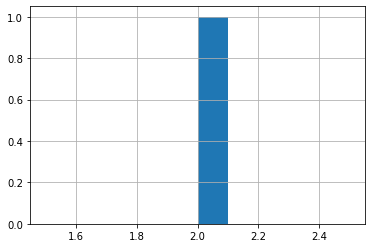

In [27]:
#Look at how a given entity2 is distribution
i = 0
#df_split_stanford.loc[df_split_stanford['entity2']==df_split_stanford.loc[i,'entity2'],'split'].hist()
df_split_stanford.loc[df_split_stanford['entity1']==df_split_stanford.loc[i,'entity1'],'split'].hist()

In [28]:
df_split_dense.loc[i,'entity2']

'Ford'

<AxesSubplot:>

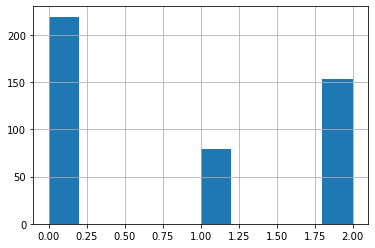

In [29]:
#Look at how a given entity2 is distribution
i = 0
df_split_dense.loc[df_split_dense['entity2']==df_split_dense.loc[i,'entity2'],'split'].hist()

In [30]:
def pd_entropy(labels):
  vc = pd.Series(labels).value_counts(normalize=True, sort=False)
  return np.sum(-(vc * np.log(vc)))

def corpus_entropy(df_split,entity='entity1'):
  return pd.DataFrame([pd_entropy(df_split.loc[df_split[entity]==df_split.loc[i,entity],'split']) for i in range(len(df_split[entity].unique()))],index=df_split[entity].unique(),columns=["entropy_" +entity])


In [31]:
entropy_stanford_entity1 = corpus_entropy(df_split_stanford,entity='entity1').describe()
entropy_stanford_entity2 = corpus_entropy(df_split_stanford,entity='entity2').describe()
entropy_stanford_pair = corpus_entropy(df_split_stanford,entity='pair').describe()
entropy_stanford = pd.concat([entropy_stanford_entity1,entropy_stanford_entity2,entropy_stanford_pair],axis=1)
print("Stanford Split:")
entropy_stanford.round(2)

Stanford Split:


,entropy_entity1,entropy_entity2,entropy_pair
count,604.0,642.00,6157.0
mean,0.0,0.78,0.0
std,0.0,0.25,0.0
min,0.0,0.00,0.0
25%,0.0,0.72,0.0
50%,0.0,0.86,0.0
75%,0.0,0.92,0.0
max,0.0,1.09,0.0


In [32]:
entropy_dense_entity1 = corpus_entropy(df_split_dense,entity='entity1').describe()
entropy_dense_entity2 = corpus_entropy(df_split_dense,entity='entity2').describe()
entropy_dense_pair = corpus_entropy(df_split_dense,entity='pair').describe()
entropy_dense = pd.concat([entropy_dense_entity1,entropy_dense_entity2,entropy_dense_pair],axis=1)
print("Dense Split:")
entropy_dense.round(2)

Dense Split:


,entropy_entity1,entropy_entity2,entropy_pair
count,604.00,642.00,6157.0
mean,0.85,0.82,0.0
std,0.23,0.24,0.0
min,0.00,0.00,0.0
25%,0.93,0.78,0.0
50%,0.93,0.87,0.0
75%,0.93,0.99,0.0
max,1.09,1.09,0.0


# Store file sentences for later use

In [33]:
#Full Data 
df.to_csv(get_data_path() + "/df_full.tsv",sep='\t')
#Splits under Stanford Split
df_split_stanford.loc[df_split_stanford['split']==0,:].to_csv(get_data_path() + "/df_train_stanford.tsv",sep='\t')
df_split_stanford.loc[df_split_stanford['split']==1,:].to_csv(get_data_path() + "/df_val_stanford.tsv",sep='\t')
df_split_stanford.loc[df_split_stanford['split']==2,:].to_csv(get_data_path() + "/df_test_stanford.tsv",sep='\t')
#Splits under Dense Split
df_split_dense.loc[df_split_dense['split']==0,:].to_csv(get_data_path() + "/df_train_dense.tsv",sep='\t')
df_split_dense.loc[df_split_dense['split']==1,:].to_csv(get_data_path() + "/df_val_dense.tsv",sep='\t')
df_split_dense.loc[df_split_dense['split']==2,:].to_csv(get_data_path() + "/df_test_dense.tsv",sep='\t')
#Store KB File
kb.to_csv(get_data_path() + "/kb_supplier_rel_only.tsv",sep='\t')